With this notebook you can reproduce the results from the paper <br> **X-ray irradiation and evaporation of the four young planets around V1298 Tau - Poppenhaeger, Ketzer, Mallonn (2020)**
.

# Import

In [1]:
import sys
sys.path.append('../platypos_package/')

# Planet Class
from Planet_class_LoFo14_PAPER import planet_LoFo14_PAPER # this is the code with fixed step size
from Planet_class_LoFo14 import planet_LoFo14 # this is the code with variable step size
from Planet_class_Ot20_PAPER import planet_Ot20_PAPER # this is the code with fixed step size
from Planet_class_Ot20 import planet_Ot20  # this is the code with variable step size
import Planet_models_LoFo14 as plmo14
import Planet_model_Ot20 as plmoOt20
from Lx_evo_and_flux import Lx_evo, flux_at_planet_earth

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
matplotlib.rcParams.update({'font.size': 18, 'legend.fontsize': 14})
mpl.rcParams['axes.linewidth'] = 1.1 #set the value globally
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import matplotlib.ticker as ticker
import os
from astropy import constants as const
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
from PyAstronomy import pyasl

p = "../supplementary_files/"
# Tu et al. (2015) - model tracks
blueTu15 = pd.read_csv(p+'Lx_blue_track.csv')
redTu15 = pd.read_csv(p+'Lx_red_track.csv')
greenTu15 = pd.read_csv(p+'Lx_green_track.csv')
                    
# Jackson et al. (2012) - Lx sample
jack12 = pd.read_csv(p+"Jackson2012_Lx_clean.csv")

def read_results_file(path, filename):
    # read in results files
    df = pd.read_csv(path+filename)
    t, M, R, Lx = df["Time"].values, df["Mass"].values, df["Radius"].values, df["Lx"].values
    return t, M, R, Lx

## Present V1298 Tau parameters, $L_x$ evolutionary tracks, and planet models
First we need to define all the necessary system parameters. <br>
This includes the host star parameters, parameters to set the shape of the assumed future $L_x$ evolutionary tracks, and the planets themselves. <br>
To model the radius evolution of the planets we use the results from *Lopez & Fortney (2014)* and *Otegi et al. (2020)*.

In [2]:
# Stellar Parameters:
L_sun = const.L_sun
L_bol = 0.934 # David et al. 2019
mass_star, radius_star = 1.101, 1.345 # solar units
age_star = 23. # Myr
Lx_age = Lx_chandra = 1.3e30  # erg/s in energy band: (0.1-2.4 keV), error +- 1.4e29
# use dictionary to store star-parameters
star_V1298Tau = {'star_id': 'V1298Tau', 'mass': mass_star, 'radius': radius_star, 'age': age_star, 'L_bol': L_bol, 'Lx_age': Lx_age}
age = star_V1298Tau["age"]

# Lx evolutionary tracks:
# create dictionaries with all the values necessary to create the evolutionary paths
Lx_1Gyr = 2.10*10**28  # Lx value at 1 Gyr from Tu et al. (2015) model tracks
Lx_5Gyr = 1.65*10**27  # Lx value at 5 Gyr from Tu et al. (2015) model tracks
track1 = {"t_start": age, "t_sat": 240., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track2 = {"t_start": age, "t_sat": age, "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
#track2_2 = {"t_start": age, "t_sat": 70., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20., "Lx_drop_factor": 5.}
#track2_3 = {"t_start": age, "t_sat": 100., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track3 = {"t_start": age, "t_sat": age, "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20., "Lx_drop_factor": 16.}

# Create planet objects using either LoFO14 or Ot20 results:
# 'fluffy' LoFo14 planets with 5 M_earth core
planet_c = {"core_mass": 5.0, "radius": 5.59, "distance": 0.0825, "metallicity": "solarZ"}
planet_d = {"core_mass": 5.0, "radius": 6.41, "distance": 0.1083, "metallicity": "solarZ"}
planet_b = {"core_mass": 5.0, "radius": 10.27, "distance": 0.1688, "metallicity": "solarZ"}
planet_e = {"core_mass": 5.0, "radius": 8.74, "distance": 0.308, "metallicity": "solarZ"}

# fixed step size
pl_c_5_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_c)
pl_d_5_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_d)
pl_b_5_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_b)
pl_e_5_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_e)

# variable step size
pl_c_5 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_c)
pl_d_5 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_d)
pl_b_5 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_b)
pl_e_5 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_e)

# 'fluffy' LoFo14 planets with 10 M_earth core
planet_c = {"core_mass": 10.0, "radius": 5.59, "distance": 0.0825, "metallicity": "solarZ"}
planet_d = {"core_mass": 10.0, "radius": 6.41, "distance": 0.1083, "metallicity": "solarZ"}
planet_b = {"core_mass": 10.0, "radius": 10.27, "distance": 0.1688, "metallicity": "solarZ"}
planet_e = {"core_mass": 10.0, "radius": 8.74, "distance": 0.308, "metallicity": "solarZ"}

# fixed step size
pl_c_10_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_c)
pl_d_10_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_d)
pl_b_10_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_b)
pl_e_10_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_e)

# variable step size
pl_c_10 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_c)
pl_d_10 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_d)
pl_b_10 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_b)
pl_e_10 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_e)

# 'high-density' Ot20 planets
planet_c = {"radius": 5.59, "distance": 0.0825}
planet_d = {"radius": 6.41, "distance": 0.1083}
planet_b = {"radius": 10.27, "distance": 0.1688}
planet_e = {"radius": 8.74, "distance": 0.308}

# fixed step size
pl_c_Ot_PAPER = planet_Ot20_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_c)
pl_d_Ot_PAPER = planet_Ot20_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_d)
pl_b_Ot_PAPER = planet_Ot20_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_b)
pl_e_Ot_PAPER = planet_Ot20_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_e)

# variable step size
pl_c_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_c)
pl_d_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_d)
pl_b_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_b)
pl_e_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_e)

## Plot current V1298 Tau $L_x$ & evolutionary tracks

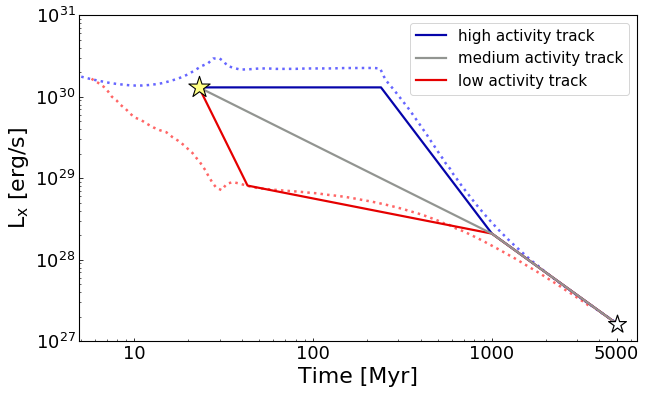

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
#ax.set_title('$L_x$ evolution for different "evolutionary tracks"')

# plot Tu15 tracks (for a Sun-like star!)
ax.plot(blueTu15["time"], blueTu15["Lx"], marker="None", linestyle=":", color="blue", linewidth=2.5, alpha=0.6, label="__nolabel__")#, label="fast rot. (solar model)")
ax.plot(redTu15["time"], redTu15["Lx"], marker="None", linestyle=":", color="red", linewidth=2.5, alpha=0.6, label="__nolabel__")#, label="slow rot. (solar model)")
#ax.plot(greenTu15["time"], greenTu15["Lx"], marker="None", linestyle=":", color="lime", linewidth=2.5, alpha=0.5, label="__nolabel__")#, label="interm. rot. (solar model)")

# plot approximated tracks
step_size, t_track_start, t_track_end = 1., age, 5000. # Myr
t_arr = np.arange(t_track_start, t_track_end+step_size, step_size)
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track1) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:royal blue", ls="-", zorder=2, label="high activity track", lw=2.2)
#####
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track2) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:grey", zorder=3, lw=2.2, alpha=1., label="medium activity track")
#####
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track3) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:red", zorder=2, label="low activity track", alpha=1, ls="-", lw=2.2)

# plot current X-ray luminosity of V1298 Tau as measured with Chandra & the assumed X-ray luminosity at 5 Gyr
ax.scatter(age, Lx_chandra, marker='*', c='xkcd:pale yellow', edgecolors='black', linewidths=1.1, s=500, alpha=1, zorder=4, label="__nolabel__")#, label="today"
ax.scatter(5000., Lx_5Gyr, marker='*', c='white', edgecolors='black', linewidths=1.2, s=350, zorder=4, label="__nolabel__")#,  label="at 5 Gyr"

ax.loglog()
ax.set_xlabel("Time [Myr]", fontsize=22)
ax.set_ylabel("L$_\mathrm{x}$ [erg/s]", fontsize=22)
ax.set_xticks([10, 100, 1000, 5000])
ax.set_yticks([10**27., 10**28., 10**29., 10**30., 10**31.])
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
ax.set_xlim(left=4.9, right=6500)
ylim = ax.get_ylim()
ax.set_ylim(abs(ylim[0]), ylim[1])
ax.set_ylim(10.**27, ylim[1])
ax.tick_params(direction="in", which="both", labelsize=18)
ax.legend(loc="best", fontsize=15)
#plt.savefig("./Plots_PAPER/Activity_tracks_v1298Tau_largelabels.jpg", dpi=300)
#plt.savefig("./Plots_PAPER/Fig8_largelabels.jpg", dpi=300)

plt.show()

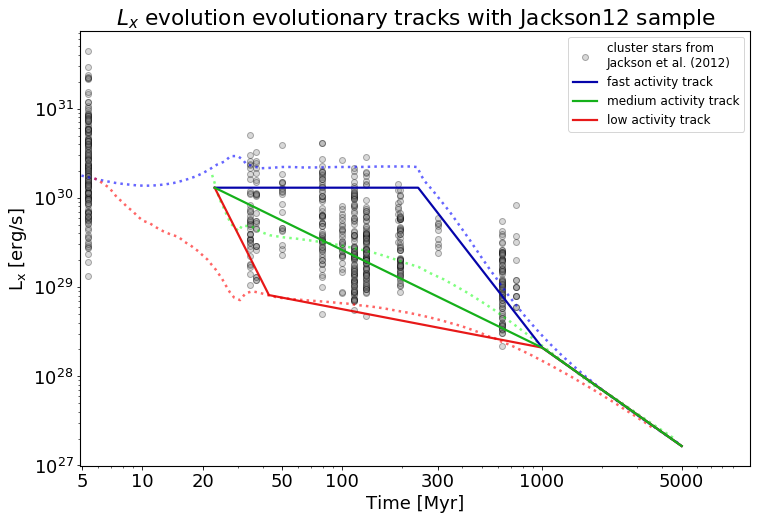

In [30]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('$L_x$ evolution evolutionary tracks with Jackson12 sample')

# plot Tu15 tracks (for a Sun-like star!)
ax.plot(blueTu15["time"], blueTu15["Lx"], marker="None", linestyle=":", color="blue", linewidth=2.5, alpha=0.6, label="__nolabel__")#, label="fast rot. (solar model)")
ax.plot(redTu15["time"], redTu15["Lx"], marker="None", linestyle=":", color="red", linewidth=2.5, alpha=0.6, label="__nolabel__")#, label="slow rot. (solar model)")
ax.plot(greenTu15["time"], greenTu15["Lx"], marker="None", linestyle=":", color="lime", linewidth=2.5, alpha=0.5, label="__nolabel__")#, label="interm. rot. (solar model)")
ax.plot(jack["age"]/1e6, 10**jack["logLx_cgs"], ls="None", marker="o", color="grey", mec="k", alpha=0.3, zorder=1, label="cluster stars from \nJackson et al. (2012)")

# plot approximated tracks
step_size, t_track_start, t_track_end = 1., age, 5000. # Myr
t_arr = np.arange(t_track_start, t_track_end+step_size, step_size)
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track1) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:royal blue", ls="-", zorder=2, label="fast activity track", lw=2.2)
#####
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track2) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:green", zorder=3, lw=2.2, alpha=1., label="medium activity track")
#####
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track3) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:red", zorder=2, label="low activity track", alpha=0.9, ls="-", lw=2.2)

ax.loglog()
ax.set_xlabel("Time [Myr]")
ax.set_ylabel("L$_\mathrm{x}$ [erg/s]")
ax.set_xticks([5, 10, 20, 50, 100, 300, 1000, 5000])
ax.set_yticks([10**27., 10**28., 10**29., 10**30., 10**31.])
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
ax.set_xlim(left=4.9, right=11000)
ylim = ax.get_ylim()
ax.set_ylim(abs(ylim[0]), ylim[1])
ax.legend(loc="best", fontsize=12)
#plt.savefig("./tracks_v1298Tau.png", dpi=300)
plt.show()

# Evolve LoFo14_PAPER planets (fixed step size)

### Evolve LoFo14_PAPER planets w. 10 Mcore

In [31]:
%%time
try:
    p = os.getcwd()+"/LoFo14_Results_PAPER/10_Mcore/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    try:
        os.mkdir(os.getcwd()+"/LoFo14_Results_PAPER/")
        os.mkdir(os.getcwd()+"/LoFo14_Results_PAPER/10_Mcore/")
        curr_path = os.getcwd()+"/LoFo14_Results_PAPER/10_Mcore/"
        print(curr_path)
    except:  
        print("Path exists")
        curr_path = os.getcwd()+"/LoFo14_Results_PAPER/10_Mcore/"
        print(curr_path)
    
folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# set epsilon, the step size, and how far into the future you want to evolve the planet
eps, step_size, t_final = 0.1, 0.1, 5000.
# planet c
folder = folders[0]
pl_c_10_PAPER.evolve_forward(t_final=t_final, initial_step_size=step_size, epsilon=eps, K_on="yes", beta_on="yes", 
                             evo_track_dict=track1, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_10P, M1_c_10P, R1_c_10P, Lx1_c_10 = pl_c_10_PAPER.read_results(curr_path+folder+"/")
pl_c_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_10P, M2_c_10P, R2_c_10P, Lx2_c_10 = pl_c_10_PAPER.read_results(curr_path+folder+"/")
pl_c_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_10P, M3_c_10P, R3_c_10P, Lx3_c_10 = pl_c_10_PAPER.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_10P, M1_d_10P, R1_d_10P, Lx1_d_10P = pl_d_10_PAPER.read_results(curr_path+folder+"/")
pl_d_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_10P, M2_d_10P, R2_d_10P, Lx2_d_10P = pl_d_10_PAPER.read_results(curr_path+folder+"/")
pl_d_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_10P, M3_d_10P, R3_d_10P, Lx3_d_10P = pl_d_10_PAPER.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_10P, M1_b_10P, R1_b_10P, Lx1_b_10P_2 = pl_b_10_PAPER.read_results(curr_path+folder+"/")
pl_b_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_10P, M2_b_10P, R2_b_10P, Lx2_b_10P_2 = pl_b_10_PAPER.read_results(curr_path+folder+"/")
pl_b_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_10P, M3_b_10P, R3_b_10P, Lx3_b_10P_2 = pl_b_10_PAPER.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_10P, M1_e_10P, R1_e_10P, Lx1_e_10P_2 = pl_e_10_PAPER.read_results(curr_path+folder+"/")
pl_e_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_10P, M2_e_10P, R2_e_10P, Lx2_e_10P_2 = pl_e_10_PAPER.read_results(curr_path+folder+"/")
pl_e_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_10P, M3_e_10P, R3_e_10P, Lx3_e_10P_2 = pl_e_10_PAPER.read_results(curr_path+folder+"/")

/media/laura/SSD2lin/PhD/work/gitlab/platypos/example_V1298Tau/LoFo14_Results_PAPER/10_Mcore/
Planet:  planet_c_track_23.0_240.0_5000.0_1.3e+30_0.0_0.0.txt
Start evolving.
stepsize= 0.10000200928288694


../platypos_package/Planet_models_LoFo14.py:20: RuntimeWarning: invalid value encountered in double_scalars
  R_env = 2.06 * (M_p)**(-0.21) * (fenv/5)**0.59 * (F_p)**0.044 * ((age/1e3)/5)**(age_exponent[metallicity]) # R_earth


Atmosphere has evaportated! Only bare rocky core left! STOP this madness!
192.80341176234526
192.80341176234526
Saved!
Planet:  planet_c_track_23.0_23.0_5000.0_1.3e+30_0.0_0.0.txt
Start evolving.
stepsize= 0.10000200928288694
Done!
Saved!
Planet:  planet_c_track_23.0_23.0_5000.0_1.3e+30_20.0_16.0.txt
Start evolving.
stepsize= 0.10000200928288694


KeyboardInterrupt: 

### Evolve LoFo14_PAPER planets w. 5 Mcore

In [5]:
%%time
try:
    p = os.getcwd()+"/LoFo14_Results_PAPER/5_Mcore/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    try:
        os.mkdir(os.getcwd()+"/LoFo14_Results_PAPER/")
        os.mkdir(os.getcwd()+"/LoFo14_Results_PAPER/5_Mcore/")
        curr_path = os.getcwd()+"/LoFo14_Results_PAPER/5_Mcore/"
        print(curr_path)
    except:  
        print("Path exists")
        curr_path = os.getcwd()+"/LoFo14_Results_PAPER/5_Mcore/"
        print(curr_path)
    
folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# set epsilon, the step size, and how far into the future you want to evolve the planet
eps, step_size, t_final = 0.1, 0.1, 5000.
# planet c
folder = folders[0]
pl_c_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_5P, M1_c_5P, R1_c_5P, Lx1_c_5P = pl_c_5_PAPER.read_results(curr_path+folder+"/")
pl_c_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_5P, M2_c_5P, R2_c_5P, Lx2_c_5P = pl_c_5_PAPER.read_results(curr_path+folder+"/")
pl_c_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_5P, M3_c_5P, R3_c_5P, Lx3_c_5P = pl_c_5_PAPER.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_5P, M1_d_5P, R1_d_5P, Lx1_d_5P = pl_d_5_PAPER.read_results(curr_path+folder+"/")
pl_d_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_5P, M2_d_5P, R2_d_5P, Lx2_d_5P = pl_d_5_PAPER.read_results(curr_path+folder+"/")
pl_d_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_5P, M3_d_5P, R3_d_5P, Lx3_d_5P = pl_d_5_PAPER.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_5P, M1_b_5P, R1_b_5P, Lx1_b_5P_2 = pl_b_5_PAPER.read_results(curr_path+folder+"/")
pl_b_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_5P, M2_b_5P, R2_b_5P, Lx2_b_5P_2 = pl_b_5_PAPER.read_results(curr_path+folder+"/")
pl_b_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_5P, M3_b_5P, R3_b_5P, Lx3_b_5P_2 = pl_b_5_PAPER.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_5P, M1_e_5P, R1_e_5P, Lx1_e_5P_2 = pl_e_5_PAPER.read_results(curr_path+folder+"/")
pl_e_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_5P, M2_e_5P, R2_e_5P, Lx2_e_5P_2 = pl_e_5_PAPER.read_results(curr_path+folder+"/")
pl_e_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_5P, M3_e_5P, R3_e_5P, Lx3_e_5P_2 = pl_e_5_PAPER.read_results(curr_path+folder+"/")

Path exists
/media/laura/SSD2lin/PhD/work/gitlab/plaml/example_V1298Tau/LoFo14_Results_PAPER/5_Mcore/
CPU times: user 293 ms, sys: 36 ms, total: 329 ms
Wall time: 330 ms


### Evolve Ot20_PAPER Planets

In [9]:
%%time
try:
    p = os.getcwd()+"/Otegi_results_PAPER/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    print("Path exists")
    curr_path = os.getcwd()+"/Otegi_results_PAPER/"
    print(curr_path)

folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# set epsilon, the step size, and how far into the future you want to evolve the planet
eps, step_size, t_final = 0.1, 1., 5000.
# planet c
folder = folders[0]
pl_c_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_OtP, M1_c_OtP, R1_c_OtP, Lx1_c_OtP = pl_c_Ot_PAPER.read_results(curr_path+folder+"/")
pl_c_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_OtP, M2_c_OtP, R2_c_OtP, Lx2_c_OtP = pl_c_Ot_PAPER.read_results(curr_path+folder+"/")
pl_c_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_OtP, M3_c_OtP, R3_c_OtP, Lx3_c_OtP = pl_c_Ot_PAPER.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_OtP, M1_d_OtP, R1_d_OtP, Lx1_d_OtP = pl_d_Ot_PAPER.read_results(curr_path+folder+"/")
pl_d_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_OtP, M2_d_OtP, R2_d_OtP, Lx2_d_OtP = pl_d_Ot_PAPER.read_results(curr_path+folder+"/")
pl_d_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_OtP, M3_d_OtP, R3_d_OtP, Lx3_d_OtP = pl_d_Ot_PAPER.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_OtP, M1_b_OtP, R1_b_OtP, Lx1_b_OtP = pl_b_Ot_PAPER.read_results(curr_path+folder+"/")
pl_b_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_OtP, M2_b_OtP, R2_b_OtP, Lx2_b_OtP = pl_b_Ot_PAPER.read_results(curr_path+folder+"/")
pl_b_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_OtP, M3_b_OtP, R3_b_OtP, Lx3_b_OtP = pl_b_Ot_PAPER.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_OtP, M1_e_OtP, R1_e_OtP, Lx1_e_OtP = pl_e_Ot_PAPER.read_results(curr_path+folder+"/")
pl_e_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_OtP, M2_e_OtP, R2_e_OtP, Lx2_e_OtP = pl_e_Ot_PAPER.read_results(curr_path+folder+"/")
pl_e_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_OtP, M3_e_OtP, R3_e_OtP, Lx3_e_OtP = pl_e_Ot_PAPER.read_results(curr_path+folder+"/")

Path exists
/media/laura/SSD2lin/PhD/work/gitlab/platypos/example_V1298Tau/Otegi_results_PAPER/
Planet:  planet_c_track_23.0_240.0_5000.0_1.3e+30_0.0_0.0.txt
Start evolving.
Done!
Saved!
CPU times: user 20.6 s, sys: 7.63 ms, total: 20.6 s
Wall time: 20.6 s


# Evolve LoFo14 planets (code with variable step size)

### Evolve LoFo14 planets w. 10 Mcore

In [6]:
%%time
try:
    p = os.getcwd()+"/LoFo14_Results_varstep/10_Mcore/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    try:
        os.mkdir(os.getcwd()+"/LoFo14_Results_varstep/")
        os.mkdir(os.getcwd()+"/LoFo14_Results_varstep/10_Mcore/")
        curr_path = os.getcwd()+"/LoFo14_Results_varstep/10_Mcore/"
        print(curr_path)
    except:  
        print("Path exists")
        curr_path = os.getcwd()+"/LoFo14_Results_varstep/10_Mcore/"
        print(curr_path)
    
folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# set epsilon, the step size, and how far into the future you want to evolve the planet
eps, step_size, t_final = 0.1, 0.1, 5000.
# planet c
folder = folders[0]
pl_c_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_10, M1_c_10, R1_c_10, Lx1_c_10 = pl_c_10.read_results(curr_path+folder+"/")
pl_c_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_10, M2_c_10, R2_c_10, Lx2_c_10 = pl_c_10.read_results(curr_path+folder+"/")
pl_c_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_10, M3_c_10, R3_c_10, Lx3_c_10 = pl_c_10.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_10, M1_d_10, R1_d_10, Lx1_d_10 = pl_d_10.read_results(curr_path+folder+"/")
pl_d_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_10, M2_d_10, R2_d_10, Lx2_d_10 = pl_d_10.read_results(curr_path+folder+"/")
pl_d_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_10, M3_d_10, R3_d_10, Lx3_d_10 = pl_d_10.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_10, M1_b_10, R1_b_10, Lx1_b_10_2 = pl_b_10.read_results(curr_path+folder+"/")
pl_b_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_10, M2_b_10, R2_b_10, Lx2_b_10_2 = pl_b_10.read_results(curr_path+folder+"/")
pl_b_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_10, M3_b_10, R3_b_10, Lx3_b_10_2 = pl_b_10.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_10, M1_e_10, R1_e_10, Lx1_e_10_2 = pl_e_10.read_results(curr_path+folder+"/")
pl_e_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_10, M2_e_10, R2_e_10, Lx2_e_10_2 = pl_e_10.read_results(curr_path+folder+"/")
pl_e_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_10, M3_e_10, R3_e_10, Lx3_e_10_2 = pl_e_10.read_results(curr_path+folder+"/")

Path exists
/media/laura/SSD2lin/PhD/work/gitlab/plaml/example_V1298Tau/LoFo14_Results_new/10_Mcore/
CPU times: user 66.8 ms, sys: 0 ns, total: 66.8 ms
Wall time: 66.6 ms


### Evolve LoFo14 planets w. 5 Mcore

In [7]:
%%time
try:
    p = os.getcwd()+"/LoFo14_Results_varstep/5_Mcore/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    try:
        os.mkdir(os.getcwd()+"/LoFo14_Results_varstep/")
        os.mkdir(os.getcwd()+"/LoFo14_Results_varstep/5_Mcore/")
        curr_path = os.getcwd()+"/LoFo14_Results_varstep/5_Mcore/"
        print(curr_path)
    except:  
        print("Path exists")
        curr_path = os.getcwd()+"/LoFo14_Results_varstep/5_Mcore/"
        print(curr_path)
    
folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# set epsilon, the step size, and how far into the future you want to evolve the planet
eps, step_size, t_final = 0.1, 0.1, 5000.
# planet c
folder = folders[0]
pl_c_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_5, M1_c_5, R1_c_5, Lx1_c_5 = pl_c_5.read_results(curr_path+folder+"/")
pl_c_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_5, M2_c_5, R2_c_5, Lx2_c_5 = pl_c_5.read_results(curr_path+folder+"/")
pl_c_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_5, M3_c_5, R3_c_5, Lx3_c_5 = pl_c_5.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_5, M1_d_5, R1_d_5, Lx1_d_5 = pl_d_5.read_results(curr_path+folder+"/")
pl_d_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_5, M2_d_5, R2_d_5, Lx2_d_5 = pl_d_5.read_results(curr_path+folder+"/")
pl_d_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_5, M3_d_5, R3_d_5, Lx3_d_5 = pl_d_5.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_5, M1_b_5, R1_b_5, Lx1_b_5_2 = pl_b_5.read_results(curr_path+folder+"/")
pl_b_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_5, M2_b_5, R2_b_5, Lx2_b_5_2 = pl_b_5.read_results(curr_path+folder+"/")
pl_b_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_5, M3_b_5, R3_b_5, Lx3_b_5_2 = pl_b_5.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_5, M1_e_5, R1_e_5, Lx1_e_5_2 = pl_e_5.read_results(curr_path+folder+"/")
pl_e_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_5, M2_e_5, R2_e_5, Lx2_e_5_2 = pl_e_5.read_results(curr_path+folder+"/")
pl_e_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_5, M3_e_5, R3_e_5, Lx3_e_5_2 = pl_e_5.read_results(curr_path+folder+"/")

Path exists
/media/laura/SSD2lin/PhD/work/gitlab/plaml/example_V1298Tau/LoFo14_Results_new/5_Mcore/
CPU times: user 50.8 ms, sys: 7.93 ms, total: 58.7 ms
Wall time: 58.4 ms


### Evolve Ot20 Planets

In [87]:
%%time
try:
    p = os.getcwd()+"/Otegi_results_varstep/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    print("Path exists")
    curr_path = os.getcwd()+"/Otegi_results_varstep/"
    print(curr_path)

folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# set epsilon, the step size, and how far into the future you want to evolve the planet
eps, step_size, t_final = 0.1, 1., 5000.
# planet c
folder = folders[0]
pl_c_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_Ot, M1_c_Ot, R1_c_Ot, Lx1_c_Ot = pl_c_Ot.read_results(curr_path+folder+"/")
pl_c_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_Ot, M2_c_Ot, R2_c_Ot, Lx2_c_Ot = pl_c_Ot.read_results(curr_path+folder+"/")
pl_c_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_Ot, M3_c_Ot, R3_c_Ot, Lx3_c_Ot = pl_c_Ot.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_Ot, M1_d_Ot, R1_d_Ot, Lx1_d_Ot = pl_d_Ot.read_results(curr_path+folder+"/")
pl_d_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_Ot, M2_d_Ot, R2_d_Ot, Lx2_d_Ot = pl_d_Ot.read_results(curr_path+folder+"/")
pl_d_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_Ot, M3_d_Ot, R3_d_Ot, Lx3_d_Ot = pl_d_Ot.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_Ot, M1_b_Ot, R1_b_Ot, Lx1_b_Ot = pl_b_Ot.read_results(curr_path+folder+"/")
pl_b_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_Ot, M2_b_Ot, R2_b_Ot, Lx2_b_Ot = pl_b_Ot.read_results(curr_path+folder+"/")
pl_b_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_Ot, M3_b_Ot, R3_b_Ot, Lx3_b_Ot = pl_b_Ot.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_Ot, M1_e_Ot, R1_e_Ot, Lx1_e_Ot = pl_e_Ot.read_results(curr_path+folder+"/")
pl_e_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_Ot, M2_e_Ot, R2_e_Ot, Lx2_e_Ot = pl_e_Ot.read_results(curr_path+folder+"/")
pl_e_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_Ot, M3_e_Ot, R3_e_Ot, Lx3_e_Ot = pl_e_Ot.read_results(curr_path+folder+"/")

Path exists
/media/laura/SSD2lin/PhD/work/gitlab/plaml/example_V1298Tau/Otegi_results_new/
CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 35.6 ms


# Plots from the Paper

## Plot mass & radius evolution planet c

NameError: name 't1_c_Ot' is not defined

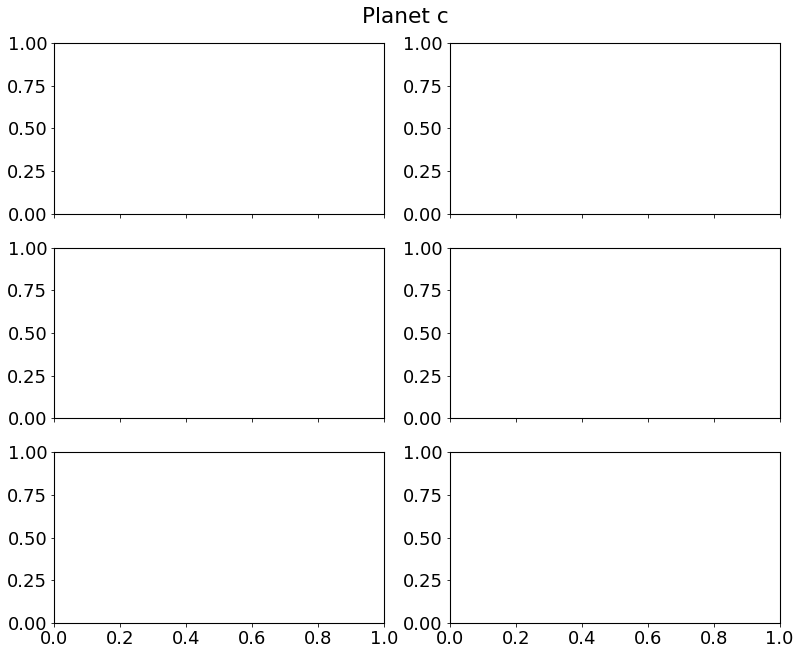

In [32]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)

fig.suptitle("Planet c")
#ax1.set_title("Planet c")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t1_c_OtP, (M1_c_OtP), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_c_OtP, (M2_c_OtP), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t3_c_OtP, (M3_c_OtP), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t1_c_10P, (M1_c_10P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_c_10P, (M2_c_10P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t3_c_10P, (M3_c_10P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[1, 0].hlines(pl_c_10_PAPER.core_mass, t1_c_10P[0], 5000., linestyle="--", color="k", lw=0.9)

# 5Mcore
axs[2, 0].plot(t1_c_5P, (M1_c_5P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_c_5P, (M2_c_5P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t3_c_5P, (M3_c_5P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_c_5_PAPER.core_mass, t1_c_5[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 0].text(1600, 5.006, "core mass", fontsize=11.5)

#radii
# Otegi/heavy
axs[0, 1].plot(t1_c_OtP, (R1_c_OtP), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_c_OtP, (R2_c_OtP), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t3_c_OtP, (R3_c_OtP), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t1_c_10P, (R1_c_10P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_c_10P, (R2_c_10P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t3_c_10P, (R3_c_10P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_c_10_PAPER.core_mass, pl_c_10_PAPER.fenv, age_arr, pl_c_10_PAPER.flux, pl_c_10_PAPER.metallicity), color="k", ls=":", lw=1)
axs[1, 1].hlines(plmo14.calculate_core_radius(pl_c_10_PAPER.core_mass), pl_c_10_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)

dy = 1.25
axs[2, 1].text(575, 3.19+dy, "thermal contraction", fontsize=11.5, rotation=-12.5)
axs[2, 1].text(570, 2.82+dy, "without mass loss", fontsize=11.5, rotation=-12.5)
#xkcd:goldenrod

# 5 mcore
axs[2, 1].plot(t1_c_5P, (R1_c_5P), label=r"fast track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_c_5P, (R2_c_5P), label=r"medim track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t3_c_5P, (R3_c_5P), label=r"slow track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_c_5_PAPER.core_mass, pl_c_5_PAPER.fenv, age_arr, pl_c_5_PAPER.flux, pl_c_5_PAPER.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_c_5_PAPER.core_mass), pl_c_5_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
axs[2, 1].text(1475, 1.55, "core radius", fontsize=11.5)

axs[0, 0].legend(fontsize=10, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

ylim = axs[2, 0].get_ylim()
axs[2, 0].set_ylim(top=ylim[1]+0.02)
ylim = axs[1, 0].get_ylim()
axs[1, 0].set_ylim(top=11.02)
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./planet_c_EVO_eps01_Zsun.jpg", dpi=300)
plt.show()

### Planet c - larger labels for in-text plot

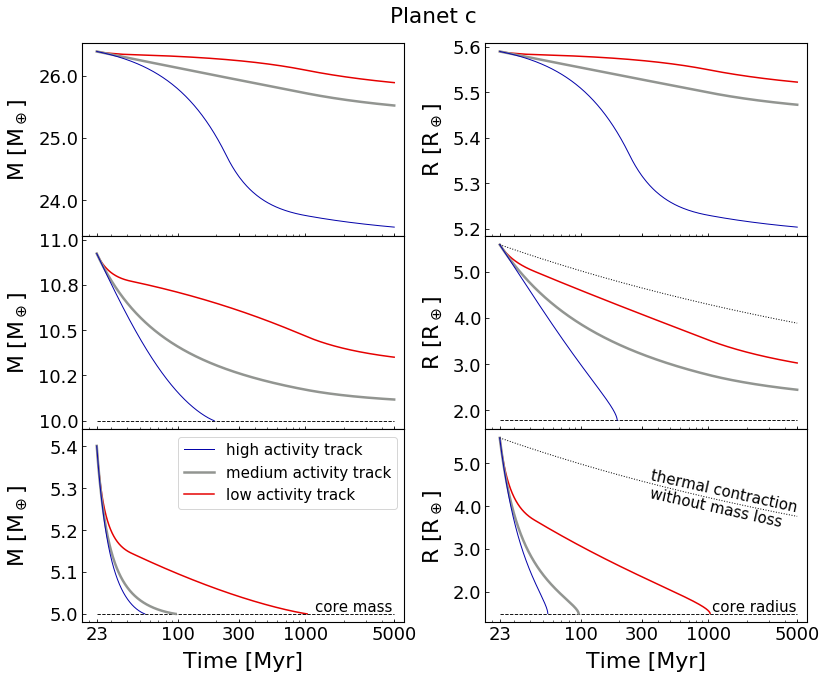

In [144]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)
fig.suptitle("Planet c")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t1_c_OtP, (M1_c_OtP), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_c_OtP, (M2_c_OtP), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t3_c_OtP, (M3_c_OtP), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t1_c_10P, (M1_c_10P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_c_10P, (M2_c_10P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t3_c_10P, (M3_c_10P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[1, 0].hlines(pl_c_10_PAPER.core_mass, t1_c_10P[0], 5000., linestyle="--", color="k", lw=0.9)

# 5Mcore
axs[2, 0].plot(t1_c_5P, (M1_c_5P), label=r"high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_c_5P, (M2_c_5P), label=r"medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t3_c_5P, (M3_c_5P), label=r"low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_c_5_PAPER.core_mass, t1_c_5[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 0].text(1200, 5.006, "core mass", fontsize=15)

#radii
# Otegi/heavy
axs[0, 1].plot(t1_c_OtP, (R1_c_OtP), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_c_OtP, (R2_c_OtP), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t3_c_OtP, (R3_c_OtP), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t1_c_10P, (R1_c_10P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_c_10P, (R2_c_10P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t3_c_10P, (R3_c_10P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_c_10_PAPER.core_mass, pl_c_10_PAPER.fenv, age_arr, pl_c_10_PAPER.flux, pl_c_10_PAPER.metallicity), color="k", ls=":", lw=1)
axs[1, 1].hlines(plmo14.calculate_core_radius(pl_c_10_PAPER.core_mass), pl_c_10_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)

dy = 1.3
axs[2, 1].text(345, 3.31+dy, "thermal contraction", fontsize=15, rotation=-12.5)
axs[2, 1].text(340, 2.9+dy, "without mass loss", fontsize=15, rotation=-12.5)
#xkcd:goldenrod

# 5 mcore
axs[2, 1].plot(t1_c_5P, (R1_c_5P), label=r"fast track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_c_5P, (R2_c_5P), label=r"medim track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t3_c_5P, (R3_c_5P), label=r"slow track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_c_5_PAPER.core_mass, pl_c_5_PAPER.fenv, age_arr, pl_c_5_PAPER.flux, pl_c_5_PAPER.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_c_5_PAPER.core_mass), pl_c_5_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
axs[2, 1].text(1075, 1.55, "core radius", fontsize=15)

axs[2, 0].legend(fontsize=15)#, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=18)
    ax.set_xlabel("Time [Myr]", fontsize=22, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=22, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

ylim = axs[2, 0].get_ylim()
axs[2, 0].set_ylim(top=ylim[1]+0.02)
ylim = axs[1, 0].get_ylim()
axs[1, 0].set_ylim(top=11.02)
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=18)
    ax.set_xlabel("Time [Myr]", fontsize=22, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=22, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
plt.savefig("./Plots_PAPER/planet_c_EVO_eps01_Zsun_largelabels.jpg", dpi=300)
plt.savefig("./Plots_PAPER/Fig9_largelabels.jpg", dpi=300)
plt.show()

## Plot mass & radius evolution planet d

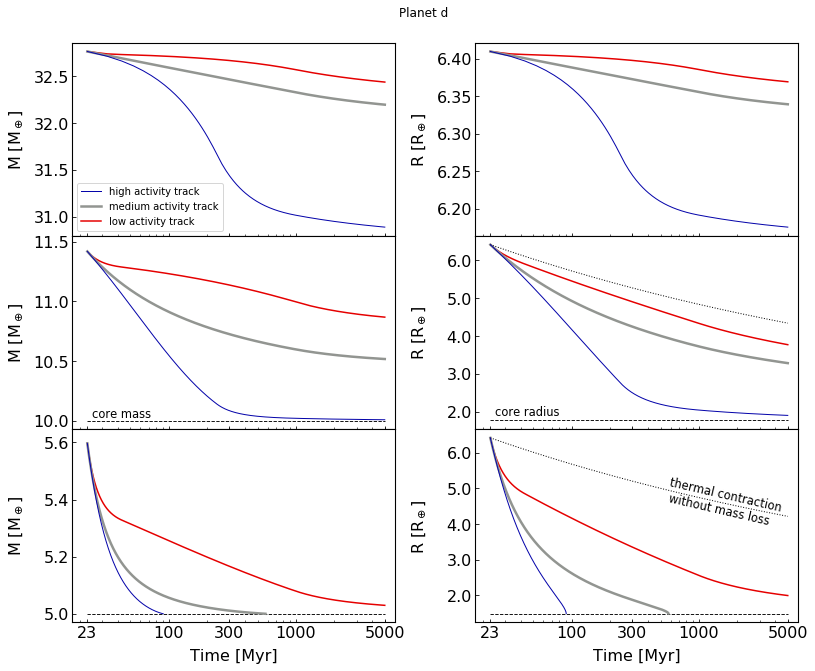

In [58]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)

fig.suptitle("Planet d")
#ax1.set_title("Planet c")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t1_d_OtP, (M1_d_OtP), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_d_OtP, (M2_d_OtP), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t3_d_OtP, (M3_d_OtP), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t1_d_10P, (M1_d_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_d_10P, (M2_d_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t3_d_10P, (M3_d_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[1, 0].hlines(pl_d_10_PAPER.core_mass, t1_d_10P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[1, 0].text(25, 10.025, "core mass", fontsize=11.5)

# 5Mcore
axs[2, 0].plot(t1_d_5P, (M1_d_5P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_d_5P, (M2_d_5P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t3_d_5P, (M3_d_5P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_d_5_PAPER.core_mass, t1_d_5P[0], 5000., linestyle="--", color="k", lw=0.9)

#radii
# Otegi/heavy
axs[0, 1].plot(t1_d_OtP, (R1_d_OtP), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_d_OtP, (R2_d_OtP), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t3_d_OtP, (R3_d_OtP), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t1_d_10P, (R1_d_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_d_10P, (R2_d_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t3_d_10P, (R3_d_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_d_10_PAPER.core_mass, pl_d_10_PAPER.fenv, age_arr, pl_d_10_PAPER.flux, pl_d_10_PAPER.metallicity), color="k", ls=":", lw=1)
axs[1, 1].hlines(plmo14.calculate_core_radius(pl_d_10_PAPER.core_mass), pl_d_10_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
axs[1, 1].text(25, 1.9, "core radius", fontsize=11.5)

# 5 mcore
axs[2, 1].plot(t1_d_5P, (R1_d_5P), label=r"fast track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_d_5P, (R2_d_5P), label=r"medim track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t3_d_5P, (R3_d_5P), label=r"slow track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_d_5_PAPER.core_mass, pl_d_5_PAPER.fenv, age_arr, pl_d_5_PAPER.flux, pl_d_5_PAPER.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_d_5_PAPER.core_mass), pl_d_5_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
dy = 1.82
axs[2, 1].text(575, 3.25+dy, "thermal contraction", fontsize=11.5, rotation=-13)
axs[2, 1].text(570, 2.8+dy, "without mass loss", fontsize=11.5, rotation=-13)

axs[0, 0].legend(fontsize=10, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

ylim = axs[2, 0].get_ylim()
axs[2, 0].set_ylim(top=ylim[1]+0.02)
ylim = axs[1, 0].get_ylim()
axs[1, 0].set_ylim(top=11.55)
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # No decimal places
plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./planet_d_EVO_eps01_Zsun.jpg", dpi=300)
plt.show()

### Planet d - larger labels for in-text plot

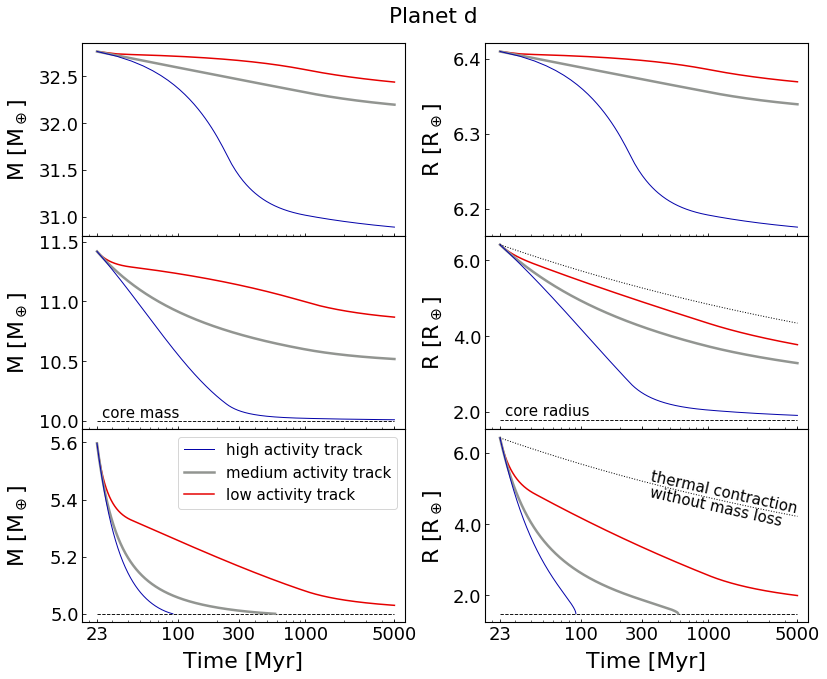

In [145]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)
fig.suptitle("Planet d")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t1_d_OtP, (M1_d_OtP), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_d_OtP, (M2_d_OtP), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t3_d_OtP, (M3_d_OtP), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t1_d_10P, (M1_d_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_d_10P, (M2_d_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t3_d_10P, (M3_d_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[1, 0].hlines(pl_d_10_PAPER.core_mass, t1_d_10P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[1, 0].text(25, 10.025, "core mass", fontsize=15)

# 5Mcore
axs[2, 0].plot(t1_d_5P, (M1_d_5P), label=r"high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_d_5P, (M2_d_5P), label=r"medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t3_d_5P, (M3_d_5P), label=r"low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_d_5_PAPER.core_mass, t1_d_5P[0], 5000., linestyle="--", color="k", lw=0.9)

#radii
# Otegi/heavy
axs[0, 1].plot(t1_d_OtP, (R1_d_OtP), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_d_OtP, (R2_d_OtP), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t3_d_OtP, (R3_d_OtP), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t1_d_10P, (R1_d_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_d_10P, (R2_d_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t3_d_10P, (R3_d_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_d_10_PAPER.core_mass, pl_d_10_PAPER.fenv, age_arr, pl_d_10_PAPER.flux, pl_d_10_PAPER.metallicity), color="k", ls=":", lw=1)
axs[1, 1].hlines(plmo14.calculate_core_radius(pl_d_10_PAPER.core_mass), pl_d_10_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
axs[1, 1].text(25, 1.9, "core radius", fontsize=15)

# 5 mcore
axs[2, 1].plot(t1_d_5P, (R1_d_5P), label=r"high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_d_5P, (R2_d_5P), label=r"medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t3_d_5P, (R3_d_5P), label=r"low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_d_5_PAPER.core_mass, pl_d_5_PAPER.fenv, age_arr, pl_d_5_PAPER.flux, pl_d_5_PAPER.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_d_5_PAPER.core_mass), pl_d_5_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)

dy = 1.88
axs[2, 1].text(345, 3.33+dy, "thermal contraction", fontsize=15, rotation=-12.5)
axs[2, 1].text(340, 2.87+dy, "without mass loss", fontsize=15, rotation=-12.5)

axs[2, 0].legend(fontsize=15)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=18)
    ax.set_xlabel("Time [Myr]", fontsize=22, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=22, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

ylim = axs[2, 0].get_ylim()
axs[2, 0].set_ylim(top=ylim[1]+0.02)
ylim = axs[1, 0].get_ylim()
axs[1, 0].set_ylim(top=11.55)
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=18)
    ax.set_xlabel("Time [Myr]", fontsize=22, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=22, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places
plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
plt.savefig("./Plots_PAPER/planet_d_EVO_eps01_Zsun_largelabels.jpg", dpi=300)
plt.savefig("./Plots_PAPER/Fig10_largelabels.jpg", dpi=300)
plt.show()

## Plot mass & radius evolution planet b

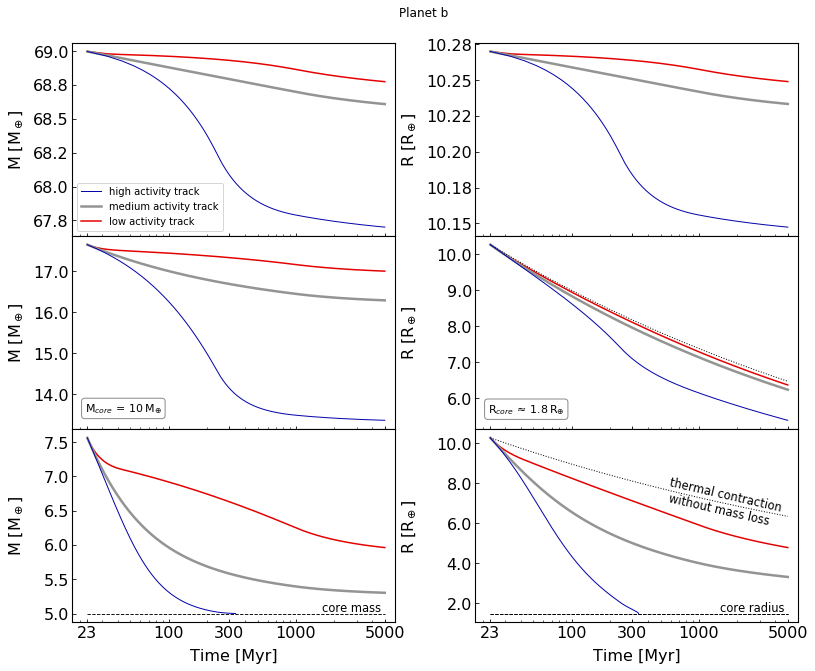

In [68]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)
fig.suptitle("Planet b")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t1_b_OtP, (M1_b_OtP), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_b_OtP, (M2_b_OtP), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t3_b_OtP, (M3_b_OtP), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t1_b_10P, (M1_b_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_b_10P, (M2_b_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t3_b_10P, (M3_b_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
#axs[1, 0].hlines(M_core10/MEc, t1_b_10[0], 5000., ls="--", color="k", lw=0.9)
#axs[1, 0].text(25, 10.025, "core mass", fontsize=11.5)

# 5Mcore
axs[2, 0].plot(t1_b_5P, (M1_b_5P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_b_5P, (M2_b_5P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t3_b_5P, (M3_b_5P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_b_5_PAPER.core_mass, t1_b_5P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 0].text(1600, 5.03, "core mass", fontsize=11.5)

#radii
# Otegi/heavy
axs[0, 1].plot(t1_b_OtP, (R1_b_OtP), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_b_OtP, (R2_b_OtP), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t3_b_OtP, (R3_b_OtP), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t1_b_10P, (R1_b_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_b_10P, (R2_b_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t3_b_10P, (R3_b_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_b_10_PAPER.core_mass, pl_b_10_PAPER.fenv, age_arr, pl_b_10_PAPER.flux, pl_b_10_PAPER.metallicity), color="k", ls=":", lw=1)

# 5 mcore
axs[2, 1].plot(t1_b_5P, (R1_b_5P), label=r"fast track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_b_5P, (R2_b_5P), label=r"medim track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t3_b_5P, (R3_b_5P), label=r"slow track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_b_5_PAPER.core_mass, pl_b_5_PAPER.fenv, age_arr, pl_b_5_PAPER.flux, pl_b_5_PAPER.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_b_5_PAPER.core_mass), pl_d_5_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
dy = 4.27
axs[2, 1].text(575, 3.6+dy, "thermal contraction", fontsize=11.5, rotation=-13)
axs[2, 1].text(570, 2.8+dy, "without mass loss", fontsize=11.5, rotation=-13)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_b_5_PAPER.core_mass), t1_b_5P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 1].text(1475, 1.62, "core radius", fontsize=11.5)

# box with core & radius for 10Mcore planet
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
axs[1, 0].text(22, 13.65, r"M$_{core}\,=\,10\,$M$_{\oplus}$", va="center", size=11, bbox=bbox_props)
axs[1, 1].text(22, 5.7, r"R$_{core}\,\approx\,1.8\,$R$_{\oplus}$", va="center", size=11, bbox=bbox_props)

axs[0, 0].legend(fontsize=10, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places
    
axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # No decimal places
plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./planet_b_EVO_eps01_Zsun.jpg", dpi=300)
plt.show()

## Plot mass & radius evolution planet e

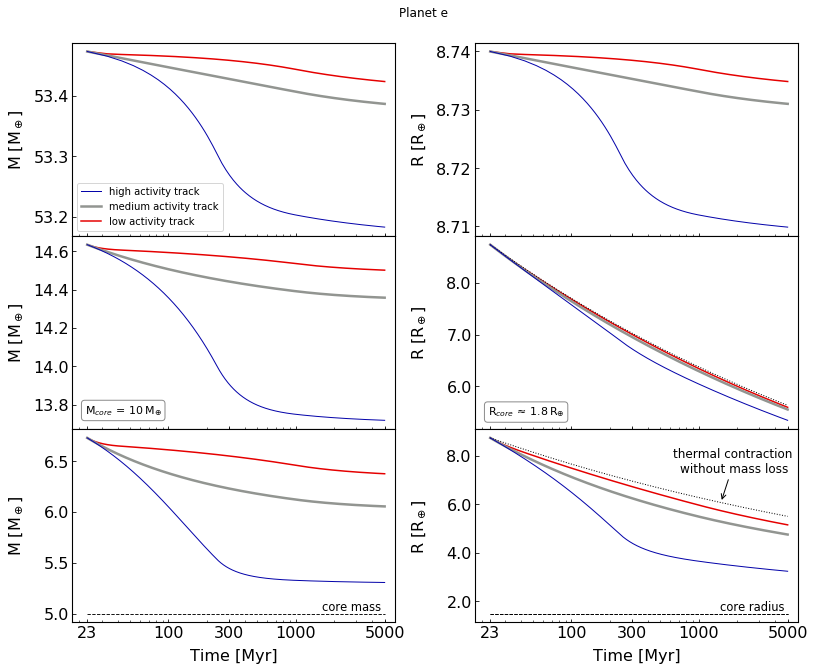

In [69]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)
fig.suptitle("Planet e")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t1_e_OtP, (M1_e_OtP), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_e_OtP, (M2_e_OtP), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t3_e_OtP, (M3_e_OtP), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t1_e_10P, (M1_e_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_e_10P, (M2_e_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t3_e_10P, (M3_e_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
#axs[1, 0].hlines(M_core10/MEc, t1_e_10[0], 5000., ls="--", color="k", lw=0.9)
#axs[1, 0].text(25, 10.025, "core mass", fontsize=11.5)

# 5Mcore
axs[2, 0].plot(t1_e_5P, (M1_e_5P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_e_5P, (M2_e_5P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t3_e_5P, (M3_e_5P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_e_5_PAPER.core_mass, t1_e_5P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 0].text(1600, 5.03, "core mass", fontsize=11.5)

#radii
# Otegi/heavy
axs[0, 1].plot(t1_e_OtP, (R1_e_OtP), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_e_OtP, (R2_e_OtP), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t3_e_OtP, (R3_e_OtP), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t1_e_10P, (R1_e_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_e_10P, (R2_e_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t3_e_10P, (R3_e_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_e_10_PAPER.core_mass, pl_e_10_PAPER.fenv, age_arr, pl_e_10_PAPER.flux, pl_e_10_PAPER.metallicity), color="k", ls=":", lw=1)

# 5 mcore
axs[2, 1].plot(t1_e_5P, (R1_e_5P), label=r"fast track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_e_5P, (R2_e_5P), label=r"medim track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t3_e_5P, (R3_e_5P), label=r"slow track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_e_5_PAPER.core_mass, pl_e_5_PAPER.fenv, age_arr, pl_e_5_PAPER.flux, pl_e_5_PAPER.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_e_5_PAPER.core_mass), pl_e_5_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
dy = 2.6
axs[2, 1].annotate('thermal contraction \nwithout mass loss', xy=(1500, 3.5+dy), xytext=(1900, 7.3), fontsize=12, ha='center',
            arrowprops=dict(arrowstyle="->"))
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_e_5_PAPER.core_mass), t1_e_5P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 1].text(1475, 1.62, "core radius", fontsize=11.5)

# box with core & radius for 10Mcore planet
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
axs[1, 0].text(22, 13.77, r"M$_{core}\,=\,10\,$M$_{\oplus}$", va="center", size=11, bbox=bbox_props)
axs[1, 1].text(22, 5.5, r"R$_{core}\,\approx\,1.8\,$R$_{\oplus}$", va="center", size=11, bbox=bbox_props)

axs[0, 0].legend(fontsize=10, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places
    
axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # No decimal places
plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./planet_e_EVO_eps01_Zsun.jpg", dpi=300)
plt.show()

## Evolution of planets in the Radius-Period diagram

In [85]:
# Instantiate exoplanetEU2 object (download all the planets)
v = pyasl.ExoplanetEU2()
# Export all data as a pandas DataFrame
planets = v.getAllDataPandas()
planets_masses = planets[~np.isnan(planets["mass"])]

mask_nan = ~(np.isnan(planets["orbital_period"]) | np.isnan(planets["radius"]))
mask_P = planets["orbital_period"]<300
planets_ = planets[mask_nan & mask_P] # dataframe only with planets which have P & R

R_to_earth = 11.2
period = planets_["orbital_period"].values
radius = planets_["radius"].values*R_to_earth
ds = planets_["semi_major_axis"].values

# actual data -> transform to log space
log3P = np.log(period)/np.log(3)
log2R = np.log(radius)/np.log(2)

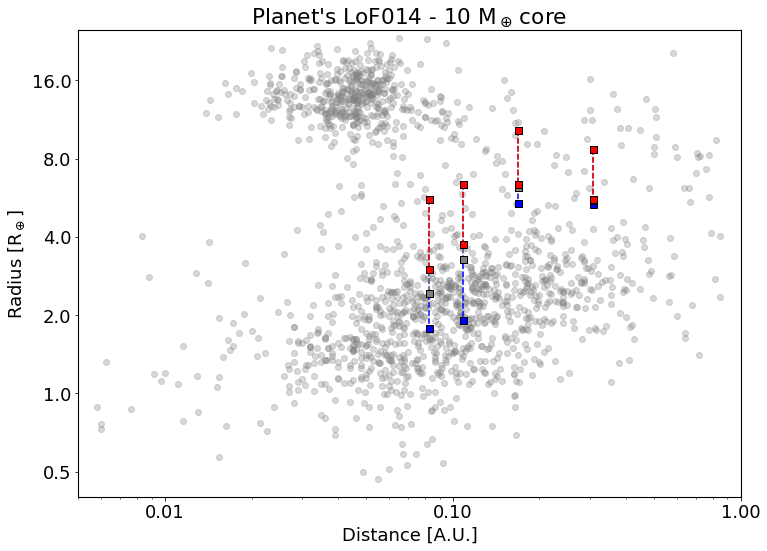

In [90]:
fig, ax = plt.subplots(figsize=(11, 8))

ax.set_title("Planet's LoF014 - 10 M$_\oplus\,$core")
ax.plot(ds, 2**log2R, marker="o", color="grey", alpha=0.3, ls="None")

ax.plot([pl_c_10.distance, pl_c_10.distance], [R1_c_10[0], R1_c_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_c_10.distance, pl_c_10.distance], [R2_c_10[0], R2_c_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_c_10.distance, pl_c_10.distance], [R3_c_10[0], R3_c_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_d_10.distance, pl_d_10.distance], [R1_d_10[0], R1_d_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_d_10.distance, pl_d_10.distance], [R2_d_10[0], R2_d_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_d_10.distance, pl_d_10.distance], [R3_d_10[0], R3_d_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_b_10.distance, pl_b_10.distance], [R1_b_10[0], R1_b_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_b_10.distance, pl_b_10.distance], [R2_b_10[0], R2_b_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_b_10.distance, pl_b_10.distance], [R3_b_10[0], R3_b_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_e_10.distance, pl_e_10.distance], [R1_e_10[0], R1_e_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_e_10.distance, pl_e_10.distance], [R2_e_10[0], R2_e_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_e_10.distance, pl_e_10.distance], [R3_e_10[0], R3_e_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.set_ylabel("Radius [R$_\oplus$]")
ax.set_xlabel("Distance [A.U.]")
ax.loglog(basey=2, basex=10)
ax.set_ylim(0.4, 25)
ax.set_xlim(0.005, 1.0)

import matplotlib.ticker
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

plt.tight_layout()
plt.show()

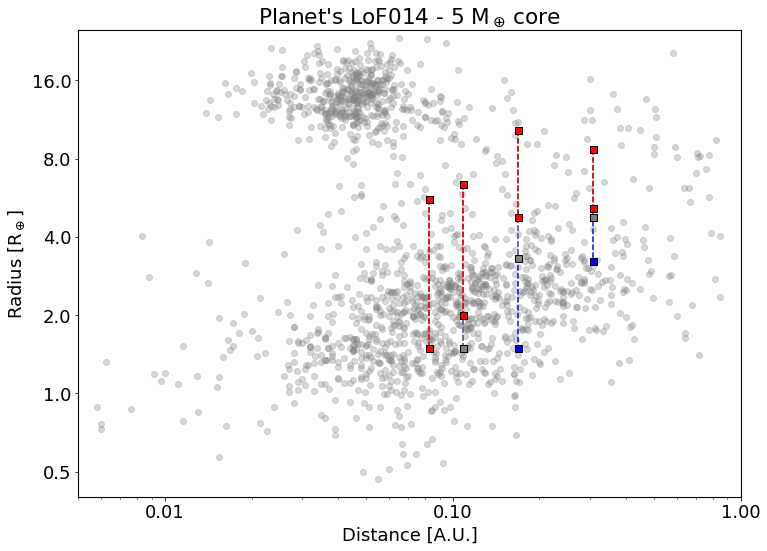

In [91]:
fig, ax = plt.subplots(figsize=(11, 8))

ax.set_title("Planet's LoF014 - 5 M$_\oplus\,$core")
ax.plot(ds, 2**log2R, marker="o", color="grey", alpha=0.3, ls="None")

ax.plot([pl_c_5.distance, pl_c_5.distance], [R1_c_5[0], R1_c_5[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_c_5.distance, pl_c_5.distance], [R2_c_5[0], R2_c_5[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_c_5.distance, pl_c_5.distance], [R3_c_5[0], R3_c_5[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_d_5.distance, pl_d_5.distance], [R1_d_5[0], R1_d_5[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_d_5.distance, pl_d_5.distance], [R2_d_5[0], R2_d_5[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_d_5.distance, pl_d_5.distance], [R3_d_5[0], R3_d_5[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_b_5.distance, pl_b_5.distance], [R1_b_5[0], R1_b_5[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_b_5.distance, pl_b_5.distance], [R2_b_5[0], R2_b_5[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_b_5.distance, pl_b_5.distance], [R3_b_5[0], R3_b_5[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_e_5.distance, pl_e_5.distance], [R1_e_5[0], R1_e_5[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_e_5.distance, pl_e_5.distance], [R2_e_5[0], R2_e_5[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_e_5.distance, pl_e_5.distance], [R3_e_5[0], R3_e_5[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.set_ylabel("Radius [R$_\oplus$]")
ax.set_xlabel("Distance [A.U.]")
ax.loglog(basey=2, basex=10)
ax.set_ylim(0.4, 25)
ax.set_xlim(0.005, 1.0)

import matplotlib.ticker
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

plt.tight_layout()
plt.show()

# Addditional stuff

In [ ]:
t1, M1, R1, Lx1 = pl_c_10.read_results("./")

In [ ]:
t, M, R # my old code goes one time step further, i.e. to 192.9 -> CHECK WHY!
# -> old results: t_end = 192.90341377162815, M_end - 5.972364730419773e+28 = 10 M_earth, R_end = 1134204390.5169253 = 1.778 = R_core

In [14]:
R1[-1], R2[-1], R3[-1]

(1.7782794100389228, 2.441383425585101, 3.0223415552531763)

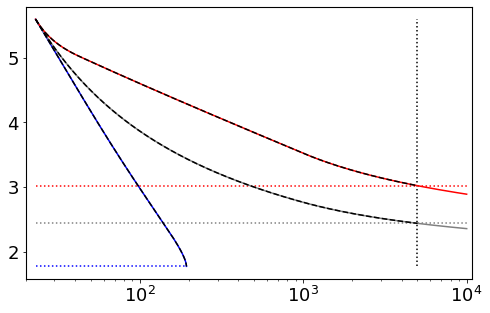

In [24]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(t1_c_10_2, R1_c_10_2, c="blue")
ax.plot(t2_c_10_2, R2_c_10_2, c="grey")
ax.plot(t3_c_10_2, R3_c_10_2, c="red")

ax.plot(t1_c_10, R1_c_10, c="k", ls="--")
ax.plot(t2_c_10, R2_c_10, c="k", ls="--")
ax.plot(t3_c_10, R3_c_10, c="k", ls="--")

ax.vlines(5000, np.min(R1_c_10), np.max(R1_c_10), ls=":", color="k")
ax.hlines(np.min(R1_c_10), np.min(t1_c_10_2), np.max(t1_c_10_2), ls=":", color="blue")
ax.hlines(np.min(R2_c_10), np.min(t2_c_10_2), np.max(t2_c_10_2), ls=":", color="grey")
ax.hlines(np.min(R3_c_10), np.min(t3_c_10_2), np.max(t3_c_10_2), ls=":", color="red")

ax.set_xticks([20,100,300,1000])
ax.set_xlim(20,10800)
ax.set_xscale("log")
plt.show()

In [39]:
R1_d_10[-1], R2_d_10[-1], R3_d_10[-1]

(1.907746135292936, 3.285915447567908, 3.772635444773706)

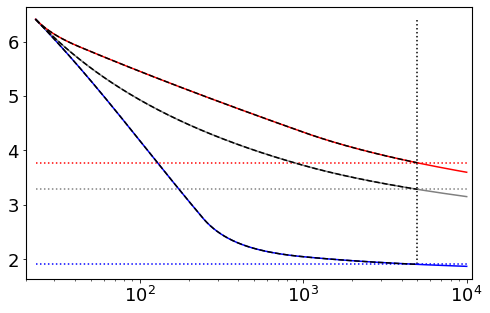

In [19]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(t1_d_10_2, R1_d_10_2, c="blue")
ax.plot(t2_d_10_2, R2_d_10_2, c="grey")
ax.plot(t3_d_10_2, R3_d_10_2, c="red")

ax.plot(t1_d_10, R1_d_10, c="k", ls="--")
ax.plot(t2_d_10, R2_d_10, c="k", ls="--")
ax.plot(t3_d_10, R3_d_10, c="k", ls="--")

ax.vlines(5000, np.min(R1_d_10), np.max(R1_d_10), ls=":", color="k")
ax.hlines(np.min(R1_d_10), np.min(t1_d_10_2), np.max(t1_d_10_2), ls=":", color="blue")
ax.hlines(np.min(R2_d_10), np.min(t2_d_10_2), np.max(t2_d_10_2), ls=":", color="grey")
ax.hlines(np.min(R3_d_10), np.min(t3_d_10_2), np.max(t3_d_10_2), ls=":", color="red")

ax.set_xticks([20,100,300,1000])
ax.set_xlim(20,10800)
ax.set_xscale("log")
plt.show()

# Plot planet population

In [26]:
# Instantiate exoplanetEU2 object (download all the planets)
v = pyasl.ExoplanetEU2()
# Export all data as a pandas DataFrame
planets = v.getAllDataPandas()
planets_masses = planets[~np.isnan(planets["mass"])]

mask_nan = ~(np.isnan(planets["orbital_period"]) | np.isnan(planets["radius"]))
mask_P = planets["orbital_period"]<300
planets_ = planets[mask_nan & mask_P] # dataframe only with planets which have P & R

R_to_earth = 11.2
period = planets_["orbital_period"].values
radius = planets_["radius"].values*R_to_earth
ds = planets_["semi_major_axis"].values

# actual data -> transform to log space
log3P = np.log(period)/np.log(3)
log2R = np.log(radius)/np.log(2)

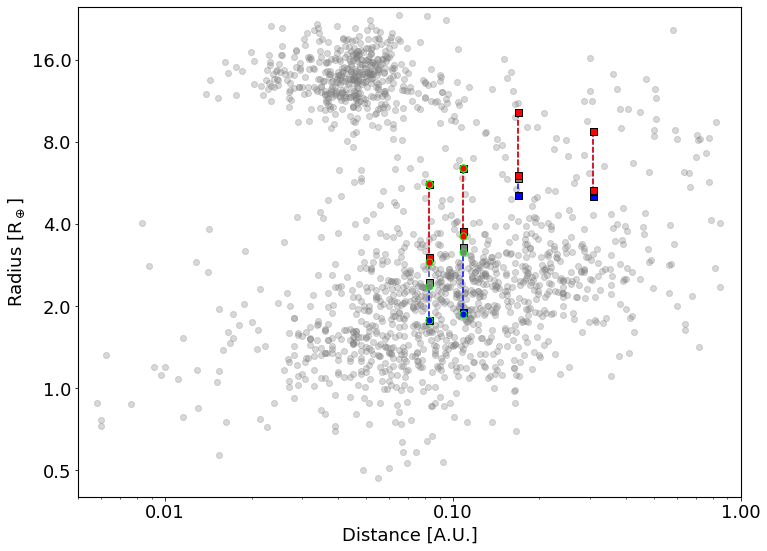

In [48]:
fig, ax = plt.subplots(figsize=(11, 8))
ax.plot(ds, 2**log2R, marker="o", color="grey", alpha=0.3, ls="None")

#ax.plot(planet_case1.distance, planet_case1.radius, marker="s", mec="k", color="aquamarine")
#ax.plot(planet_case1.distance, R1[-1], marker="s", mec="k", color="blue")
#ax.plot(planet_case1.distance, R2[-1], marker="s", mec="k", color="green")
#ax.plot(planet_case1.distance, R3[-1], marker="s", mec="k", color="darkred")

ax.plot([pl_c_10.distance, pl_c_10.distance], [R1_c_10[0], R1_c_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_c_10.distance, pl_c_10.distance], [R2_c_10[0], R2_c_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_c_10.distance, pl_c_10.distance], [R3_c_10[0], R3_c_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_c_10.distance, pl_c_10.distance], [R1_c_10_2[0], R1_c_10_2[-1]], marker="o", ms=7, mec="lime", color="blue", ls="None")
ax.plot([pl_c_10.distance, pl_c_10.distance], [R2_c_10_2[0], R2_c_10_2[-1]], marker="o", ms=7, mec="lime", color="grey", ls="None")
ax.plot([pl_c_10.distance, pl_c_10.distance], [R3_c_10_2[0], R3_c_10_2[-1]], marker="o", ms=7, mec="lime", color="red", ls="None")

ax.plot([pl_d_10.distance, pl_d_10.distance], [R1_d_10[0], R1_d_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_d_10.distance, pl_d_10.distance], [R2_d_10[0], R2_d_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_d_10.distance, pl_d_10.distance], [R3_d_10[0], R3_d_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_d_10.distance, pl_d_10.distance], [R1_d_10_2[0], R1_d_10_2[-1]], marker="o", ms=7, mec="lime", color="blue", ls="None")
ax.plot([pl_d_10.distance, pl_d_10.distance], [R2_d_10_2[0], R2_d_10_2[-1]], marker="o", ms=7, mec="lime", color="grey", ls="None")
ax.plot([pl_d_10.distance, pl_d_10.distance], [R3_d_10_2[0], R3_d_10_2[-1]], marker="o", ms=7, mec="lime", color="red", ls="None")

ax.plot([pl_b_10.distance, pl_b_10.distance], [R1_b_10[0], R1_b_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_b_10.distance, pl_b_10.distance], [R2_b_10[0], R2_b_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_b_10.distance, pl_b_10.distance], [R3_b_10[0], R3_b_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_e_10.distance, pl_e_10.distance], [R1_e_10[0], R1_e_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_e_10.distance, pl_e_10.distance], [R2_e_10[0], R2_e_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_e_10.distance, pl_e_10.distance], [R3_e_10[0], R3_e_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.set_ylabel("Radius [R$_\oplus$]")
ax.set_xlabel("Distance [A.U.]")
ax.loglog(basey=2, basex=10)
ax.set_ylim(0.4, 25)
ax.set_xlim(0.005, 1.0)

import matplotlib.ticker
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

plt.tight_layout()
plt.show()